In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Creditcard_data.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class'>

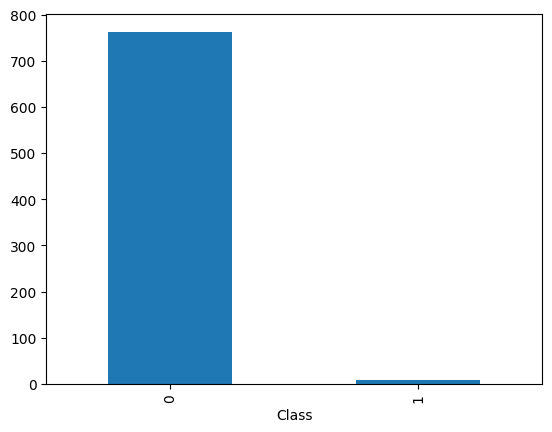

In [3]:
df['Class'].value_counts().plot(kind='bar')

In [4]:
X = df.drop(columns=["Class"])
y = df["Class"]

### Simple Random Sampling

In [5]:
def simple_random_sampling(X, y, size=0.2):
    while True:
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=size, random_state=42)
        if len(np.unique(y_sample)) > 1:
            return X_sample, y_sample

### Systematic Sampling

In [6]:
def systematic_sampling(X, y, size=0.2):
    n = len(X)
    step = max(1, int(1 / size)) 
    indices = np.arange(0, n, step)[:int(size * n)]
    X_sample = X.iloc[indices]
    y_sample = y.iloc[indices]
    if len(np.unique(y_sample)) > 1:
        return X_sample, y_sample

### Stratified Sampling

In [7]:
def stratified_sampling(X, y, size=0.2):
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=size, stratify=y, random_state=42)
    return X_sample, y_sample

### Clustering Sampling

In [8]:
def cluster_sampling(X, y, n_clusters=5):
    while True:
        clusters = pd.qcut(X.index, n_clusters, labels=False)  
        chosen_cluster = np.random.choice(range(n_clusters))
        indices = X.index[clusters == chosen_cluster]
        X_sample = X.loc[indices]
        y_sample = y.loc[indices]
        if len(np.unique(y_sample)) > 1:
            return X_sample, y_sample

### Cross Validation

In [9]:
def cross_validation_sampling(X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    return skf.split(X, y)

In [10]:
sampling_methods = {
    "Simple Random": simple_random_sampling,
    "Systematic": systematic_sampling,
    "Stratified": stratified_sampling,
    "Cluster": cluster_sampling,
    "Cross-Validation": cross_validation_sampling,
}

In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGB": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
}

In [12]:
def evaluate_models_with_sampling(X, y, sampling_methods, models):
    results = {}

    for method_name, sampler in sampling_methods.items():
        results[method_name] = {}

        if method_name == "Cross-Validation":
            # Handle cross-validation separately
            for model_name, model in models.items():
                accuracies = []
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                for train_idx, test_idx in skf.split(X, y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                    
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    accuracies.append(accuracy_score(y_test, y_pred))
                
                results[method_name][model_name] = np.mean(accuracies)
        else:
            # Handle other sampling methods
            X_sample, y_sample = sampler(X, y)
            for model_name, model in models.items():
                # Split sampled data into train-test sets
                X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)
                
                # Train and evaluate model
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                results[method_name][model_name] = accuracy
                
    return results

### Using SMOTE(Synthetic Minority Over-sampling Technique)

In [13]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [14]:
results = evaluate_models_with_sampling(X_balanced, y_balanced, sampling_methods, models)

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

### Best Sampling Method for each method

In [15]:
final_results = {}
for method, method_results in results.items():
    for model, accuracy in method_results.items():
        if model not in final_results or final_results[model]['accuracy'] < accuracy:
            final_results[model] = {'sampling_method': method, 'accuracy': accuracy}

In [16]:
print("\nBest Sampling Technique for Each Model:")
for model, result in final_results.items():
    print(f"{model}: {result['sampling_method']} with Accuracy = {result['accuracy']:.2f}")


Best Sampling Technique for Each Model:
Logistic Regression: Cluster with Accuracy = 0.96
XGB: Cross-Validation with Accuracy = 0.99
Random Forest: Cross-Validation with Accuracy = 1.00
SVM: Cluster with Accuracy = 0.83
KNN: Cluster with Accuracy = 0.86


In [17]:
df_results = pd.DataFrame(results)
df_results.to_csv("sampling_results.csv", index=True)